In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import pandas as pd
import os
from scipy import signal

import h5py
from DasTools import DasPrep as dp


datapath = '/home/disk/disk02/bluo/xfj_das/'
workpath = './'
hs_catalog_file = './xfj_20220422_111.csv'

Load RTK coordinates and times for tap tests

In [5]:
hs_cat = pd.read_csv(hs_catalog_file, sep=',', encoding='GB2312')
hs_cat.columns.tolist()[10:30]

['σE',
 'σZ',
 '平滑次数',
 '解类型',
 '开始本地时间',
 '结束本地时间',
 '开始UTC时间',
 '结束UTC时间',
 '描述',
 '差分龄期',
 '卫星数',
 '公共卫星数',
 'PDOP',
 '截止高度角(°)',
 '参考站名称',
 '基站B',
 '基站L',
 '基站H(相位中心)',
 '里程',
 '竖直倾角']

In [3]:
hs_cat['开始UTC时间']

0      2022-04-22 07:04:06.0
1      2022-04-22 07:13:59.0
2      2022-04-22 07:22:28.0
3      2022-04-22 07:34:27.0
4      2022-04-22 07:36:03.0
               ...          
141    2022-04-22 08:56:16.0
142    2022-04-22 08:56:45.0
143    2022-04-22 08:57:03.0
144    2022-04-22 08:57:34.0
145    2022-04-22 08:58:06.0
Name: 开始UTC时间, Length: 146, dtype: object

In [4]:
def get_cat_time(catalog):
    cat_time = np.array([datetime.datetime.strptime(str(catalog['开始UTC时间'].values[i]), '%Y-%m-%d %H:%M:%S.%f') 
       for i in range(len(catalog))])
    return cat_time

hs_time = get_cat_time(hs_cat)

str2deg = lambda x : (np.array(x.split(':'), dtype='float')*np.array([1, 1./60., 1./60./60.])).sum() 

lat =  np.array([str2deg(x) for x in hs_cat['B'].values])
lon =  np.array([str2deg(x) for x in hs_cat['L'].values])
dep =  hs_cat['H'].values

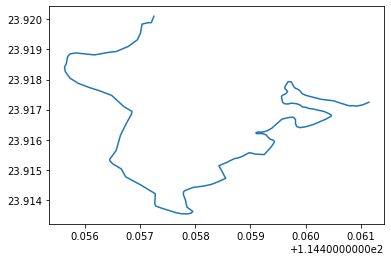

In [5]:
plt.figure()
plt.plot(lon,lat)

In [6]:
hs_time

array([datetime.datetime(2022, 4, 22, 7, 4, 6),
       datetime.datetime(2022, 4, 22, 7, 13, 59),
       datetime.datetime(2022, 4, 22, 7, 22, 28),
       datetime.datetime(2022, 4, 22, 7, 34, 27),
       datetime.datetime(2022, 4, 22, 7, 36, 3),
       datetime.datetime(2022, 4, 22, 7, 36, 57),
       datetime.datetime(2022, 4, 22, 7, 37, 46),
       datetime.datetime(2022, 4, 22, 7, 38, 46),
       datetime.datetime(2022, 4, 22, 7, 39, 39),
       datetime.datetime(2022, 4, 22, 7, 40, 18),
       datetime.datetime(2022, 4, 22, 7, 40, 48),
       datetime.datetime(2022, 4, 22, 7, 41, 24),
       datetime.datetime(2022, 4, 22, 7, 41, 51),
       datetime.datetime(2022, 4, 22, 7, 42, 31),
       datetime.datetime(2022, 4, 22, 7, 43, 8),
       datetime.datetime(2022, 4, 22, 7, 44, 2),
       datetime.datetime(2022, 4, 22, 7, 44, 35),
       datetime.datetime(2022, 4, 22, 7, 45, 17),
       datetime.datetime(2022, 4, 22, 7, 46, 6),
       datetime.datetime(2022, 4, 22, 7, 46, 47),
      

Read DAS filenames and parameters

In [7]:
%%time
das_file = glob.glob(datapath+'*.tdms')
das_file.sort()

CPU times: user 73.2 ms, sys: 35.7 ms, total: 109 ms
Wall time: 107 ms


In [9]:
das_file

['/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_005733.103.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_005833.103.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_005936.212.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_010036.212.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_010136.212.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_010242.542.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_010342.542.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_010442.542.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_010542.542.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_010642.542.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_010742.541.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_010842.541.tdms',
 '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_20220422_0109

In [10]:
# # get_das_file_time(das_file[0])

# dp.read_das(das_file[0], metadata='True')

Cut tap test events

In [8]:
def read_das_data(filename):
    data= dp.read_das(filename)
    dt = dp.read_das(das_file[0], metadata='True')['dt']
    nt = data.shape[1]
    return data, dt, nt

def get_das_file_time(das_filename, das_name_format):
    return datetime.datetime.strptime(das_filename, das_name_format)

def get_ev_id_in_das_window(event_time_arr, start_time, end_time):
    return np.where((event_time_arr > start_time) & (event_time_arr < end_time))

def get_time_step(start, end, dt):
    return int((start - end).total_seconds() / dt + 1)


def extract_das_data(das_file, das_name_format, ev_time, dt_before, dt_after, save_file_name_prefix, overwrite=False, verbose=False):
    
    das_file_time = np.array([get_das_file_time(das_file[i], das_name_format) for i in range(len(das_file))])
    
    ev_id_in_das_win = get_ev_id_in_das_window(ev_time, das_file_time.min(), das_file_time.max())
    ev_time_in_das_win = ev_time[ev_id_in_das_win]
    
    ev_time_before = ev_time_in_das_win - datetime.timedelta(seconds=dt_before)
    ev_time_after  = ev_time_in_das_win + datetime.timedelta(seconds=dt_after)

    for iev in range(len(ev_id_in_das_win[0])):

        savename = save_file_name_prefix + str(ev_id_in_das_win[0][iev]) + '.npy'
        
        if verbose: print(savename)

        if not (os.path.exists(savename) and not overwrite):

            ins_start = np.searchsorted(das_file_time, ev_time_before[iev:(iev+1)])[0] - 1
            ins_end = np.searchsorted(das_file_time, ev_time_after[iev:(iev+1)])[0]

            das_file_time_select = das_file_time[ins_start:ins_end]
            das_file_select = das_file[ins_start:ins_end]

            ev_t0 = ev_time_before[iev]
            ev_t1 = ev_time_after[iev]

            data = []
            for i in range(len(das_file_select)):
#                 print(das_file_select[i])

                datatmp, dt, nt = read_das_data(das_file_select[i])
                istart, iend = 0, np.copy(nt)

                das_t0 = das_file_time_select[i]
                das_t1 = das_t0 + datetime.timedelta(seconds=dt*nt)

                if ev_t0 > das_t0:
                    istart = get_time_step(ev_t0, das_t0, dt)

                if ev_t1 < das_t1:
                    iend = get_time_step(ev_t1, das_t0, dt)

                data.append(datatmp[:, istart:iend])

            data = np.concatenate(data, axis=1)
            if (data.size > 0):
                np.save(savename, data.astype('float32'))

In [18]:
%%time


das_name_format = '/home/disk/disk02/bluo/xfj_das/IDAS16047_xfj_UTC_%Y%m%d_%H%M%S.%f.tdms'

dt_before, dt_after = 0, 10

save_file_name_prefix = workpath + 'xfj_tap_test_cut_'

extract_das_data(das_file, das_name_format, hs_time, dt_before, dt_after, 
                 save_file_name_prefix, overwrite=False, verbose=True)

[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_0.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_1.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_2.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_3.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_4.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_5.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_6.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_7.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_8.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_9.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_10.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_11.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_12.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_13.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_14.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_15.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_16.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_17.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_18.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_19.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_20.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_21.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_22.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_23.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_24.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_25.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_26.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_27.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_28.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_29.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_30.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_31.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_32.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_33.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_34.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_35.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_36.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_37.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_38.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_39.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_40.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_41.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_42.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_43.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_44.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_45.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_46.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_47.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_48.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_49.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_50.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_51.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_52.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_53.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_54.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_55.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_56.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_57.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_58.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_59.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_60.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_61.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_62.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_63.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_64.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_65.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_66.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_67.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_68.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_69.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_70.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_71.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_72.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_73.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_74.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_75.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_76.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_77.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_78.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_79.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_80.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_81.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_82.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_83.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_84.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_85.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_86.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_87.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_88.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_89.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_90.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_91.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_92.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_93.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_94.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_95.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_96.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_97.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_98.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_99.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_100.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_101.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_102.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_103.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_104.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_105.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_106.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_107.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_108.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_109.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_110.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_111.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_112.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_113.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_114.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_115.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_116.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_117.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_118.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_119.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_120.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_121.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_122.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_123.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_124.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_125.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_126.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_127.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_128.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_129.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_130.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_131.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_132.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_133.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_134.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_135.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_136.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_137.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_138.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_139.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_140.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_141.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_142.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_143.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_144.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 105984000 is not a multiple of the chunk size 1048064. Will attempt to read last chunk


./xfj_tap_test_cut_145.npy


[nptdms.tdms_segment WARNING] Data size 108288000 is not a multiple of the chunk size 1046784. Will attempt to read last chunk


CPU times: user 17min 2s, sys: 2min 43s, total: 19min 46s
Wall time: 20min 13s


In [9]:
def bandpass(data, dt, fl, fh):
    fs=1/dt
    sos = signal.butter(6, [fl/(fs/2), fh/(fs/2)], 'bp', output='sos')
    data = signal.sosfiltfilt(sos, data, axis=1)
    return data


./xfj_tap_test_cut_20.npy


<IPython.core.display.Javascript object>


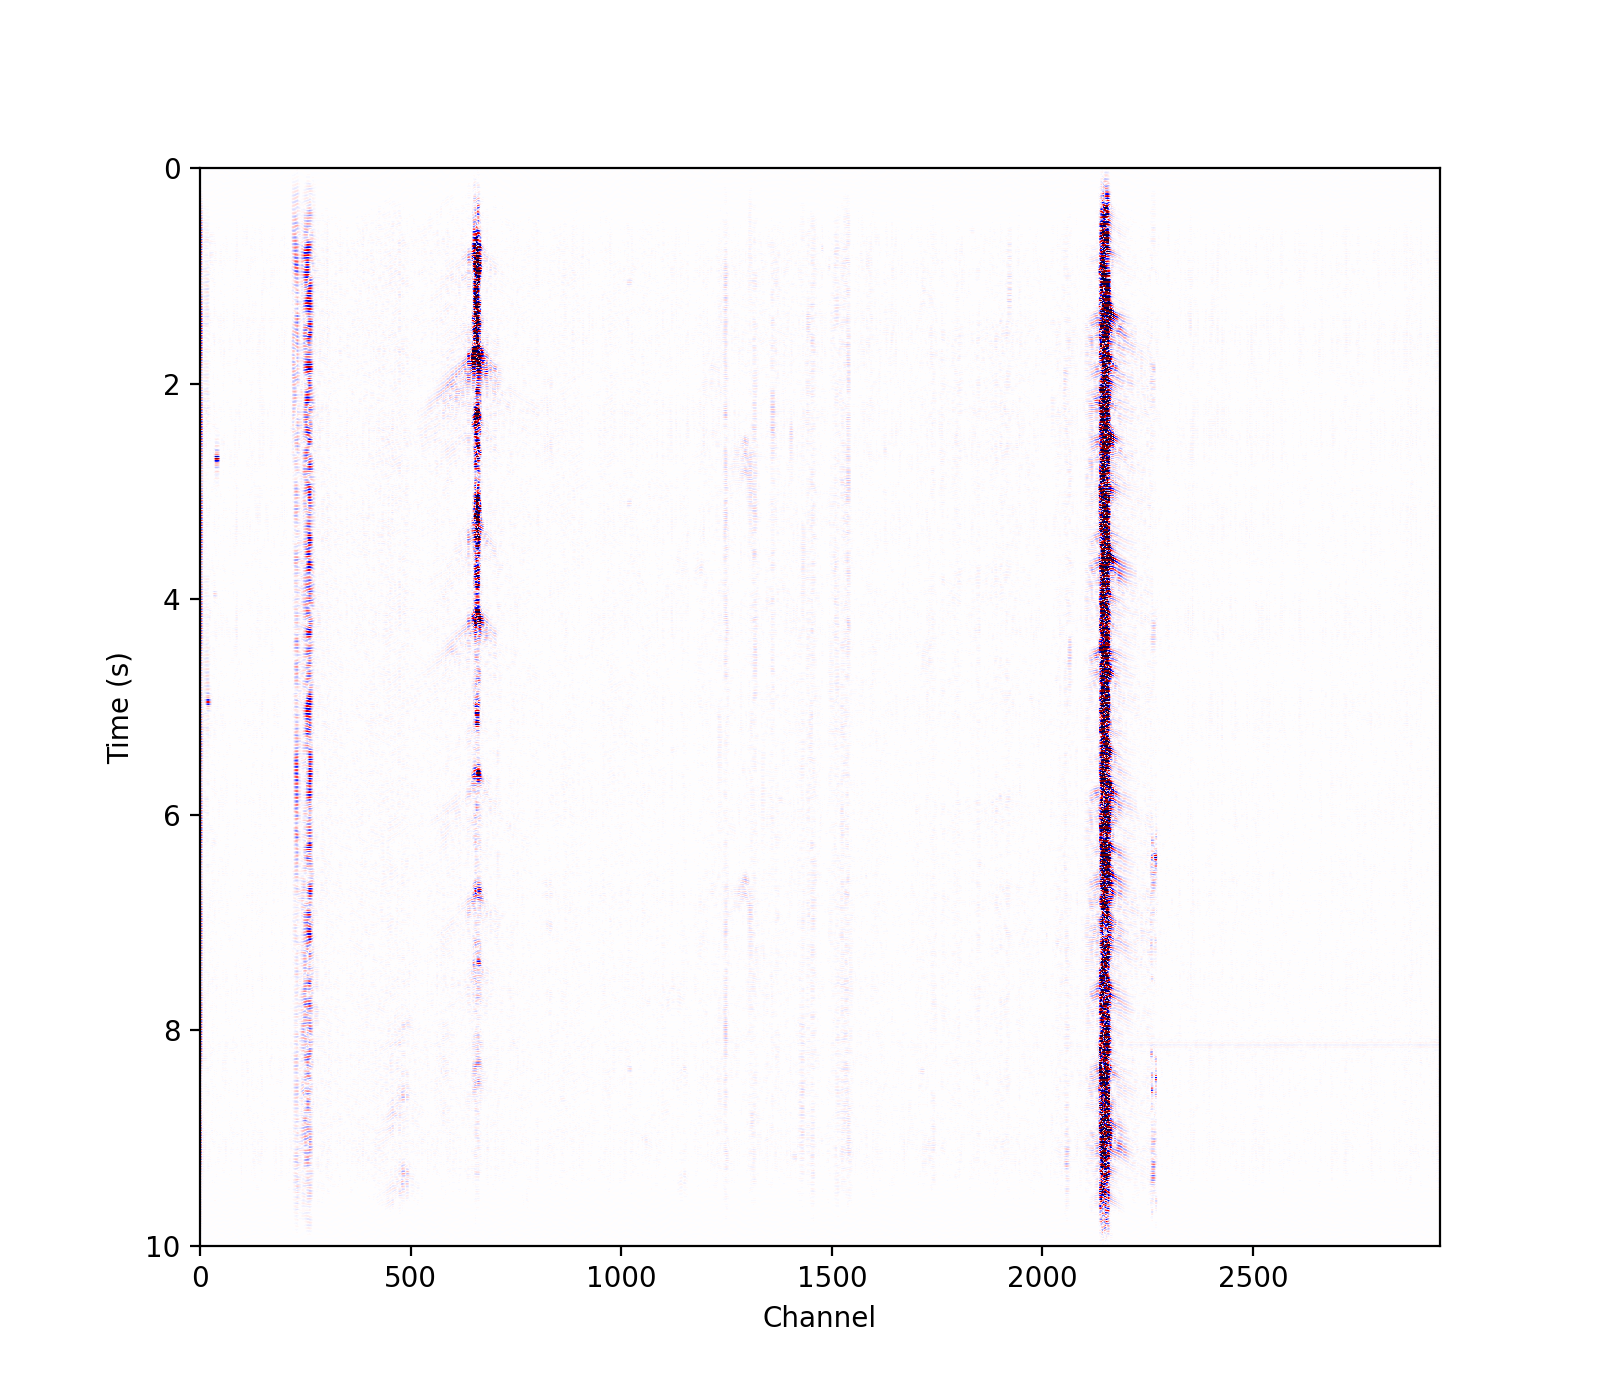

In [10]:
%matplotlib notebook
import matplotlib.animation as animation
import das_event_manual_pick as das_mp
from scipy import signal

save_file_name_prefix = workpath + 'xfj_tap_test_cut_'

iev = 20
# if len(list(click_pos.keys()))>0:
#     iev = max(list(click_pos.keys())) + 1
# else:
#     iev = 21

savename = save_file_name_prefix + str(iev) + '.npy'

dt = 1./300.
print(savename)
data = np.load(savename)

data = dp.das_preprocess(data)
f1, f2 = 15, 35
# # f1, f2 = 1, 10

data = bandpass(data * signal.tukey(data.shape[1], alpha=0.2), dt, fl=f1, fh=f2)


# https://stackoverflow.com/questions/39079562/matplotlib-animation-vertical-cursor-line-through-subplots
fig, ax = plt.subplots(figsize=[8,7])

clim = data.std() *5

ax.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
           vmin = -clim, vmax = clim,
          extent=[0,data.shape[0], data.shape[1]*dt, 0])

# ax.set_ylim([5, 1])
ax.set_xlabel('Channel')
ax.set_ylabel('Time (s)')


# plt.axvline(iev*4/0.5+ 128)

plt.show()

In [11]:
%%time
rms_all = []

dt = 1./300.

for iev in range(146):

    savename = save_file_name_prefix + str(iev) + '.npy'

    
    print(savename)
    data = np.load(savename)

    data = dp.das_preprocess(data)
    f1, f2 = 15, 35
    data = bandpass(data * signal.tukey(data.shape[1], alpha=0.2), dt, fl=f1, fh=f2)

    rms = np.sqrt((data[:,:]**2).mean(axis=1))
    
    rms_all.append(rms)

./xfj_tap_test_cut_0.npy
./xfj_tap_test_cut_1.npy
./xfj_tap_test_cut_2.npy
./xfj_tap_test_cut_3.npy
./xfj_tap_test_cut_4.npy
./xfj_tap_test_cut_5.npy
./xfj_tap_test_cut_6.npy
./xfj_tap_test_cut_7.npy
./xfj_tap_test_cut_8.npy
./xfj_tap_test_cut_9.npy
./xfj_tap_test_cut_10.npy
./xfj_tap_test_cut_11.npy
./xfj_tap_test_cut_12.npy
./xfj_tap_test_cut_13.npy
./xfj_tap_test_cut_14.npy
./xfj_tap_test_cut_15.npy
./xfj_tap_test_cut_16.npy
./xfj_tap_test_cut_17.npy
./xfj_tap_test_cut_18.npy
./xfj_tap_test_cut_19.npy
./xfj_tap_test_cut_20.npy
./xfj_tap_test_cut_21.npy
./xfj_tap_test_cut_22.npy
./xfj_tap_test_cut_23.npy
./xfj_tap_test_cut_24.npy
./xfj_tap_test_cut_25.npy
./xfj_tap_test_cut_26.npy
./xfj_tap_test_cut_27.npy
./xfj_tap_test_cut_28.npy
./xfj_tap_test_cut_29.npy
./xfj_tap_test_cut_30.npy
./xfj_tap_test_cut_31.npy
./xfj_tap_test_cut_32.npy
./xfj_tap_test_cut_33.npy
./xfj_tap_test_cut_34.npy
./xfj_tap_test_cut_35.npy
./xfj_tap_test_cut_36.npy
./xfj_tap_test_cut_37.npy
./xfj_tap_test_cut_38.

In [13]:
rms_all = np.asarray(rms_all)

np.save('shot_rms.npy', rms_all)

ss


<IPython.core.display.Javascript object>


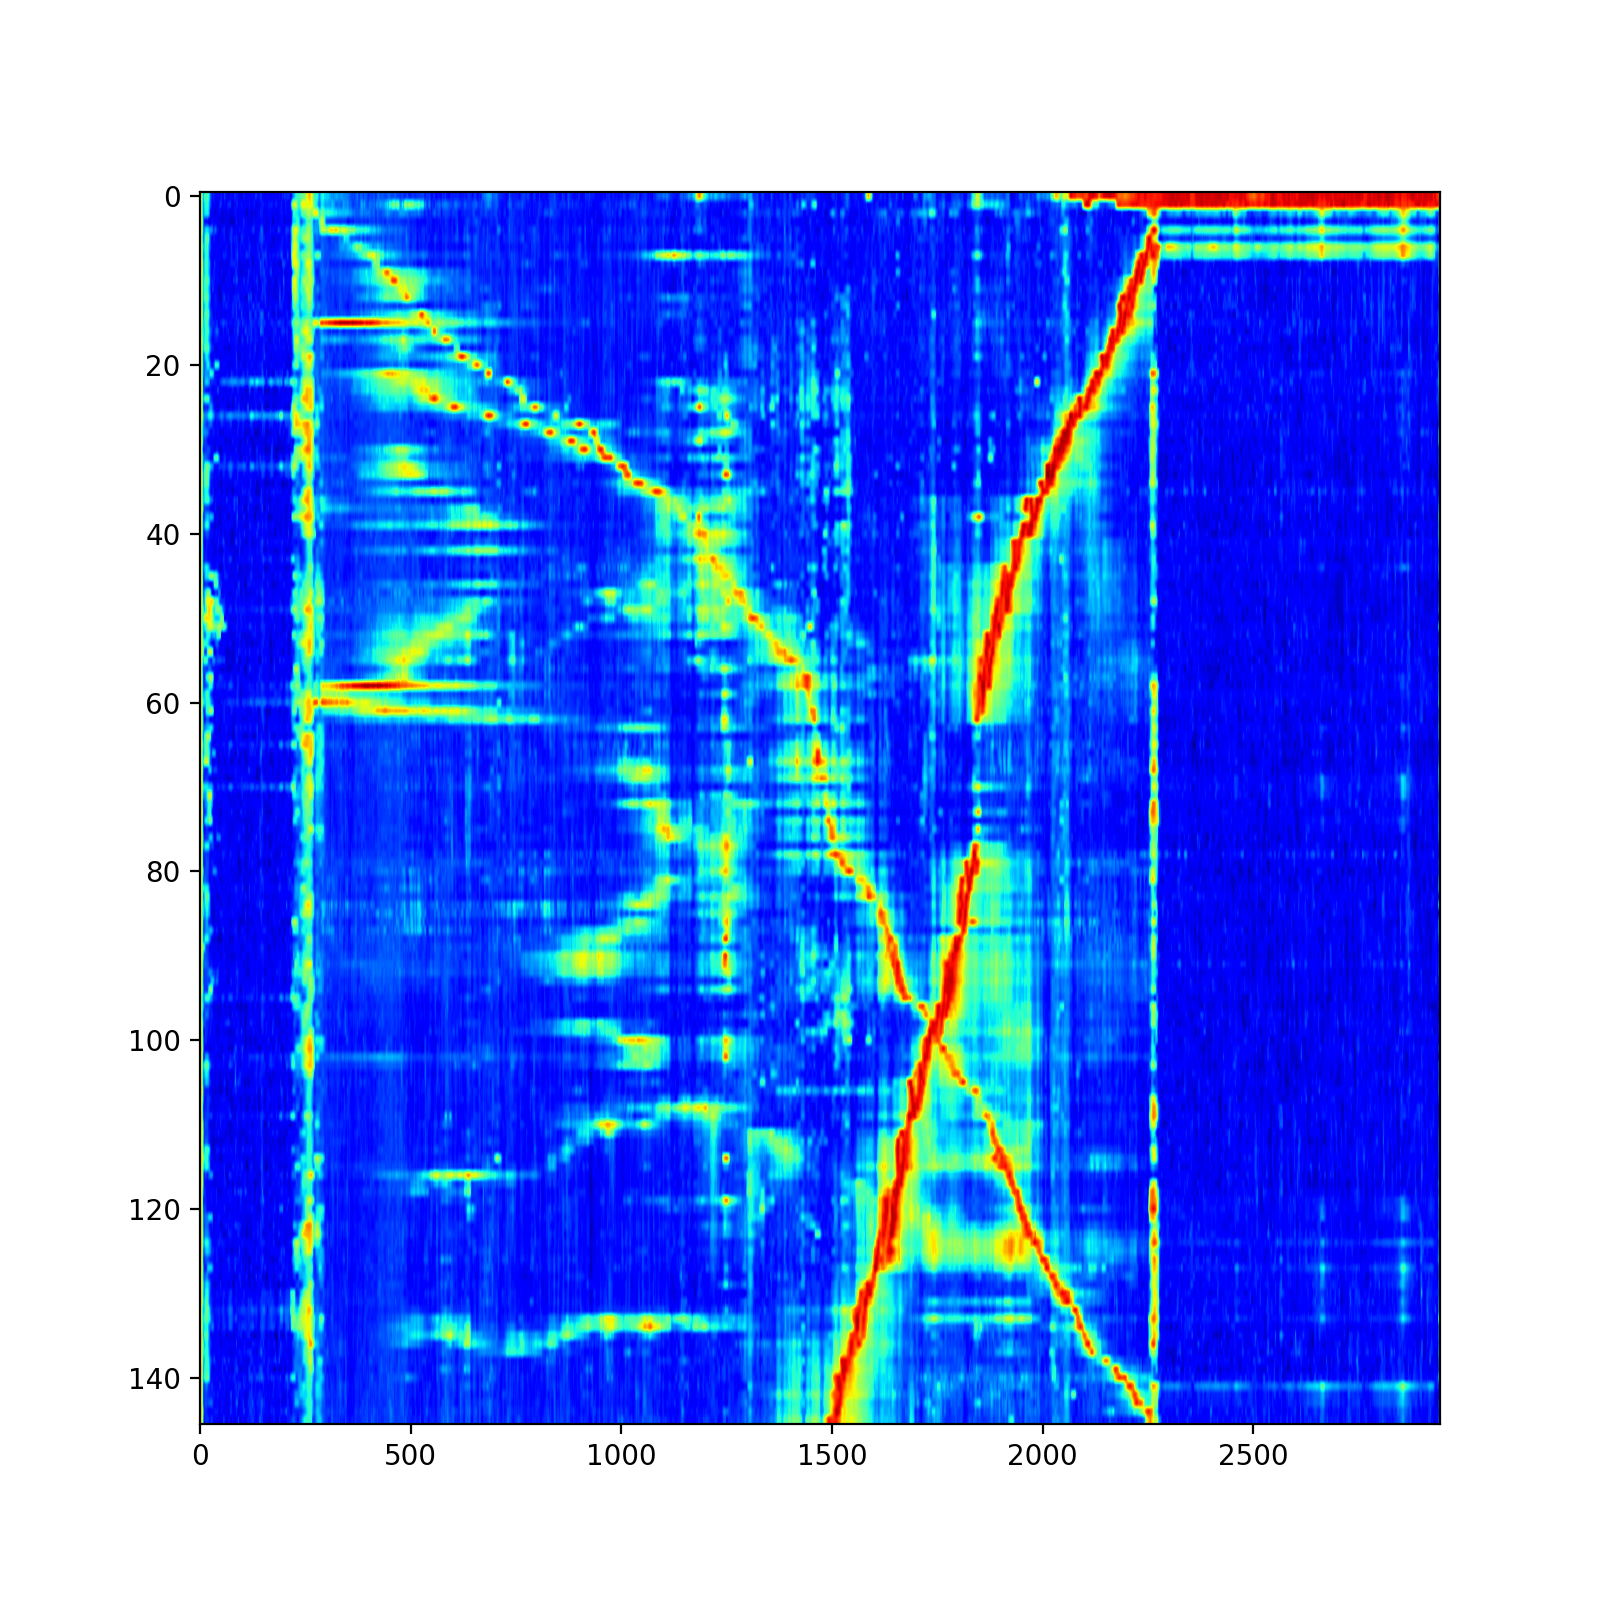

In [23]:
plt.figure(figsize=[8,8])
plt.imshow(np.log10(rms_all), aspect='auto', cmap='jet')
plt.show()

In [73]:
click_pos = {}

<IPython.core.display.Javascript object>


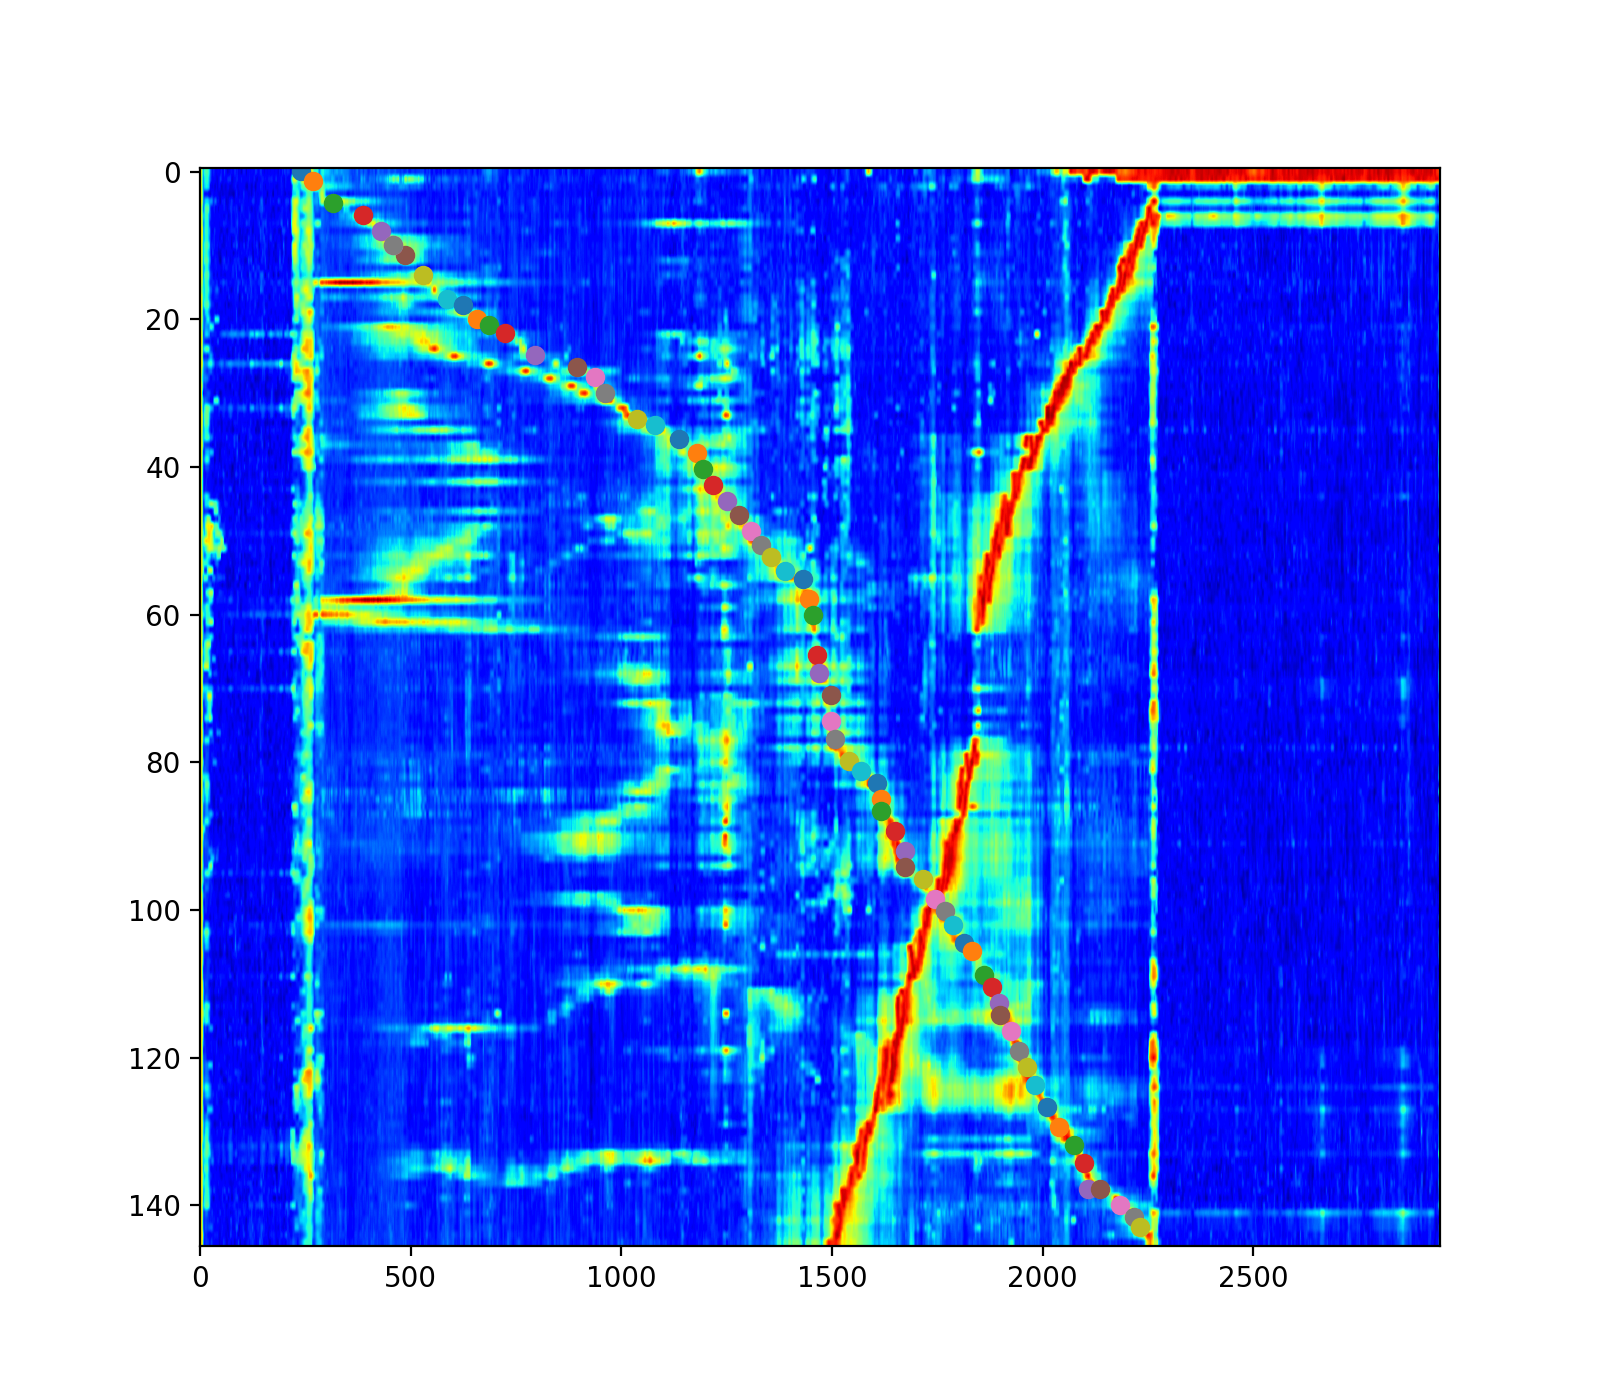

In [74]:
%matplotlib notebook
import matplotlib.animation as animation
import das_event_manual_pick as das_mp
from scipy import signal

fig, ax = plt.subplots(figsize=[8,7])
ax.imshow(np.log10(rms_all), aspect='auto', cmap='jet')



def onMouseMove(event, axx):
    axx.lines = [] #axx.lines[:1]
    axx.axhline(y=event.ydata, color="k")
    axx.axvline(x=event.xdata, color="k")
    
def onMouseClick(event, axx):
    click_pos[int(event.ydata)] = event.xdata 
    axx.scatter(x=event.xdata, y=event.ydata)

def visualize(i):
#     line1.set_ydata(val1)
    return None
    

click = das_mp.Click(ax, onMouseClick, button=1)
mm    = das_mp.MouseMove(ax, onMouseMove)

ani = animation.FuncAnimation(fig, visualize, interval=1)

plt.show()

In [70]:
click_pos

{0: 247.60322580645158,
 1: 276.09354838709675,
 3: 318.8290322580645,
 6: 404.3,
 8: 442.28709677419346,
 11: 489.7709677419354,
 13: 518.2612903225806,
 15: 542.0032258064516,
 17: 589.4870967741936,
 19: 670.2096774193549,
 18: 632.2225806451613,
 21: 727.1903225806452,
 24: 793.667741935484,
 26: 898.132258064516,
 27: 931.3709677419354,
 29: 955.1129032258063,
 31: 1002.5967741935483,
 33: 1045.332258064516,
 34: 1097.5645161290322,
 37: 1145.0483870967741,
 39: 1178.2870967741935,
 43: 1216.274193548387,
 45: 1273.2548387096774,
 50: 1315.9903225806452,
 52: 1363.4741935483871,
 55: 1406.2096774193549,
 57: 1439.4483870967742,
 61: 1458.441935483871,
 66: 1458.441935483871,
 69: 1467.9387096774194,
 72: 1491.6806451612904,
 75: 1496.4290322580646,
 77: 1515.4225806451611,
 80: 1543.9129032258063,
 81: 1581.8999999999999,
 84: 1610.390322580645,
 88: 1634.1322580645162,
 90: 1653.125806451613,
 92: 1667.3709677419354,
 94: 1672.1193548387098,
 95: 1719.6032258064517,
 98: 1748.093

In [32]:
click_pos

{0: 253.07873740467397,
 1: 261.7539429682285,
 2: 290.2581898199076,
 3: 322.48038191311,
 4: 347.2666835232658,
 5: 377.01024545545266,
 6: 401.79654706560837,
 8: 436.4973693198264,
 7: 414.18969787068625,
 9: 457.56572568845877,
 10: 474.91613681556777,
 11: 491.027232862169,
 13: 525.728055116387,
 14: 540.5998360824805,
 15: 555.4716170485739,
 16: 585.2151789807608,
 18: 622.3946313959943,
 19: 657.0954536502124,
 20: 685.5997005018914,
 21: 731.4543584806796,
 22: 758.7192902518509,
 23: 767.3944958154054,
 24: 797.1380577475923,
 25: 845.471345887396,
 26: 901.2405245102464,
 27: 934.9887973574309,
 29: 944.764069116043,
 30: 961.0561887137296,
 31: 1003.4156996677148,
 32: 1015.3632540393517,
 34: 1083.7901563496355,
 35: 1125.0635259971082,
 37: 1151.1309173534069,
 38: 1165.2507543380686,
 39: 1179.3705913227304,
 40: 1196.7488522269296,
 41: 1205.4379826790291,
 42: 1210.8686892115911,
 43: 1227.1608088092778,
 44: 1244.539069713477,
 45: 1258.6589066981387,
 46: 1279.295591521875,
 47: 1286.8985806674623,
 48: 1292.3292872000243,
 49: 1315.1382546367856,
 50: 1330.3442329279596,
 51: 1348.8086351386714,
 52: 1368.3591786558952,
 53: 1382.479015640557,
 54: 1404.201841770806,
 55: 1422.8657615252018,
 56: 1437.0134482869535,
 57: 1441.434600400001,
 59: 1449.3926742034864,
 60: 1456.4665175843622,
 61: 1458.2349784295814,
 63: 1460.0034392748003,
 64: 1461.7719001200192,
 66: 1464.4245913878476,
 67: 1469.7299739235045,
 68: 1474.1511260365521,
 70: 1476.8038173043806,
 71: 1482.993430262647,
 72: 1489.1830432209133,
 73: 1493.604195333961,
 74: 1497.1411170243987,
 75: 1504.2149604052747,
 77: 1505.9834212504936,
 78: 1523.6680297026835,
 79: 1546.65802069053,
 80: 1570.5322421009864,
 81: 1589.1010809757856,
 84: 1612.0910719636322,
 82: 1592.6380026662237,
 83: 1599.7118460470995,
 85: 1620.9333761897271,
 86: 1628.8914499932125,
 87: 1634.1968325288694,
 88: 1641.2706759097455,
 89: 1645.6918280227928,
 91: 1654.5341322488878,
 90: 1650.9972105584498,
 92: 1660.723745207154,
 93: 1667.79758858803,
 94: 1673.9872015462965,
 95: 1714.6618009863328,
 96: 1724.3883356350373,
 98: 1742.9571745098365,
 97: 1732.3464094385226,
 99: 1753.5679395811503,
 100: 1759.7575525394168,
 101: 1765.9471654976833,
 102: 1784.5160043724825,
 104: 1815.4640691638147,
 103: 1797.7794607116248,
 105: 1839.9525087049365,
 107: 1853.3204017081666,
 108: 1866.6882947113968,
 109: 1878.2738019808628,
 110: 1881.8385734483907,
 111: 1890.7505021172108,
 112: 1896.9888521853848,
 113: 1900.5536236529128,
 114: 1911.247938055497,
 115: 1921.051059591199,
 116: 1927.289409659373,
 117: 1932.636566860665,
 118: 1945.113266997013,
 119: 1944.222074130131,
 120: 1955.807581399597,
 121: 1961.154738600889,
 122: 1967.393088669063,
 123: 1978.978595938529,
 124: 1991.4552960748772,
 125: 2000.367224743697,
 126: 2006.605574811871,
 127: 2020.8646606819832,
 128: 2027.1030107501574,
 129: 2039.5797108865054,
 130: 2059.1859539579095,
 131: 2078.7921970293137,
 133: 2085.9217399643694,
 134: 2100.1808258344818,
 132: 2085.0305470974877,
 135: 2109.9839473701836,
 136: 2123.351840373414,
 138: 2171.4762551850417,
 140: 2213.3623199284957,
 139: 2186.626533922036,
 142: 2223.165441464198,
 141: 2216.927091396024,
 144: 2253.465998938186,
 145: 2265.942699074534,
 143: 2240.098105934956}

{0: 253.07873740467397,
 1: 261.7539429682285,
 2: 290.2581898199076,
 3: 322.48038191311,
 4: 347.2666835232658,
 5: 377.01024545545266,
 6: 401.79654706560837,
 8: 436.4973693198264,
 7: 414.18969787068625,
 9: 457.56572568845877,
 10: 474.91613681556777,
 11: 491.027232862169,
 13: 525.728055116387,
 14: 540.5998360824805,
 15: 555.4716170485739,
 16: 585.2151789807608,
 18: 622.3946313959943,
 19: 657.0954536502124,
 20: 685.5997005018914,
 21: 731.4543584806796,
 22: 758.7192902518509,
 23: 767.3944958154054,
 24: 797.1380577475923,
 25: 845.471345887396,
 26: 901.2405245102464,
 27: 934.9887973574309,
 29: 944.764069116043,
 30: 961.0561887137296,
 31: 1003.4156996677148,
 32: 1015.3632540393517,
 34: 1083.7901563496355,
 35: 1125.0635259971082,
 37: 1151.1309173534069,
 38: 1165.2507543380686,
 39: 1179.3705913227304,
 40: 1196.7488522269296,
 41: 1205.4379826790291,
 42: 1210.8686892115911,
 43: 1227.1608088092778,
 44: 1244.539069713477,
 45: 1258.6589066981387,
 46: 1279.2955

In [75]:
irtk, ichn = [], []
for i in click_pos.keys():
    irtk.append(int(i))
    ichn.append(click_pos[i])  
    
irtk = np.array(irtk)
irtk_argsort = np.argsort(irtk)

ichn = np.array(ichn)[irtk_argsort]
irtk = irtk[irtk_argsort]

In [76]:
irtk

array([  0,   1,   4,   5,   8,   9,  11,  13,  17,  18,  19,  20,  21,
        24,  26,  27,  29,  33,  34,  36,  38,  40,  42,  44,  46,  48,
        50,  52,  54,  55,  57,  60,  65,  67,  70,  74,  76,  79,  81,
        82,  84,  86,  89,  91,  94,  95,  98, 100, 102, 104, 105, 108,
       110, 112, 114, 116, 119, 121, 123, 126, 129, 131, 134, 137, 139,
       141, 142])

In [77]:
ichn

array([ 238.10645161,  266.59677419,  314.08064516,  385.30645161,
        428.04193548,  456.53225806,  485.02258065,  527.75806452,
        584.73870968,  622.72580645,  655.96451613,  684.45483871,
        722.44193548,  793.66774194,  893.38387097,  936.11935484,
        959.86129032, 1035.83548387, 1078.57096774, 1135.5516129 ,
       1178.28709677, 1192.53225806, 1216.27419355, 1249.51290323,
       1278.00322581, 1306.49354839, 1330.23548387, 1353.97741935,
       1387.21612903, 1429.9516129 , 1444.19677419, 1453.69354839,
       1463.19032258, 1467.93870968, 1496.42903226, 1496.42903226,
       1505.92580645, 1539.16451613, 1567.65483871, 1605.64193548,
       1615.13870968, 1615.13870968, 1648.37741935, 1672.11935484,
       1672.11935484, 1714.85483871, 1743.34516129, 1767.08709677,
       1786.08064516, 1814.57096774, 1833.56451613, 1862.05483871,
       1881.0483871 , 1895.29354839, 1900.04193548, 1923.78387097,
       1942.77741935, 1961.77096774, 1980.76451613, 2009.25483

In [78]:
from sklearn.linear_model import LinearRegression
import pyproj

def lat_lon_dep_to_interval(lat, lon, dep):
    geodesic = pyproj.Geod(ellps='WGS84')
    HdL = np.array([geodesic.inv(lon[i], lat[i], lon[i+1], lat[i+1])[2] for i in range(len(lon)-1)])
    dL = np.sqrt(HdL**2 + np.diff(dep)**2)
    return dL

def linRegModel(x,y):
    return LinearRegression().fit(x.reshape(-1,1), y)

def interpolate_lat_lon_dep(ch2rtk, rtk_hit_chn, rtk_length, lat, lon, dep):
    x_ch = np.arange(int(rtk_hit_chn.min())-1000, int(rtk_hit_chn.max())+1000)
    x_rtk = ch2rtk.predict(x_ch.reshape(-1,1))

    xch_min, xch_max = np.argwhere(x_rtk<rtk_length[0]).max(), np.argwhere(x_rtk>rtk_length[-1]).min()
   
    x_lat = np.interp(x_rtk, rtk_length, lat)[xch_min:xch_max]
    x_lon = np.interp(x_rtk, rtk_length, lon)[xch_min:xch_max]
    x_dep = np.interp(x_rtk, rtk_length, dep)[xch_min:xch_max]
    x_chn = x_ch[xch_min:xch_max]
    
    return x_chn, x_lat, x_lon, x_dep

In [79]:
# add the array_order_1 to coordinates

rtk_hit_chn = ichn

rtk_dL = lat_lon_dep_to_interval(lat, lon, dep) 
rtk_length = np.r_[0, rtk_dL].cumsum()

ch2rtk = linRegModel(rtk_hit_chn, rtk_length[irtk])

x_chn, x_lat, x_lon, x_dep = interpolate_lat_lon_dep(ch2rtk, rtk_hit_chn, rtk_length[irtk], 
                                                     lat[irtk], lon[irtk], dep[irtk])

<IPython.core.display.Javascript object>


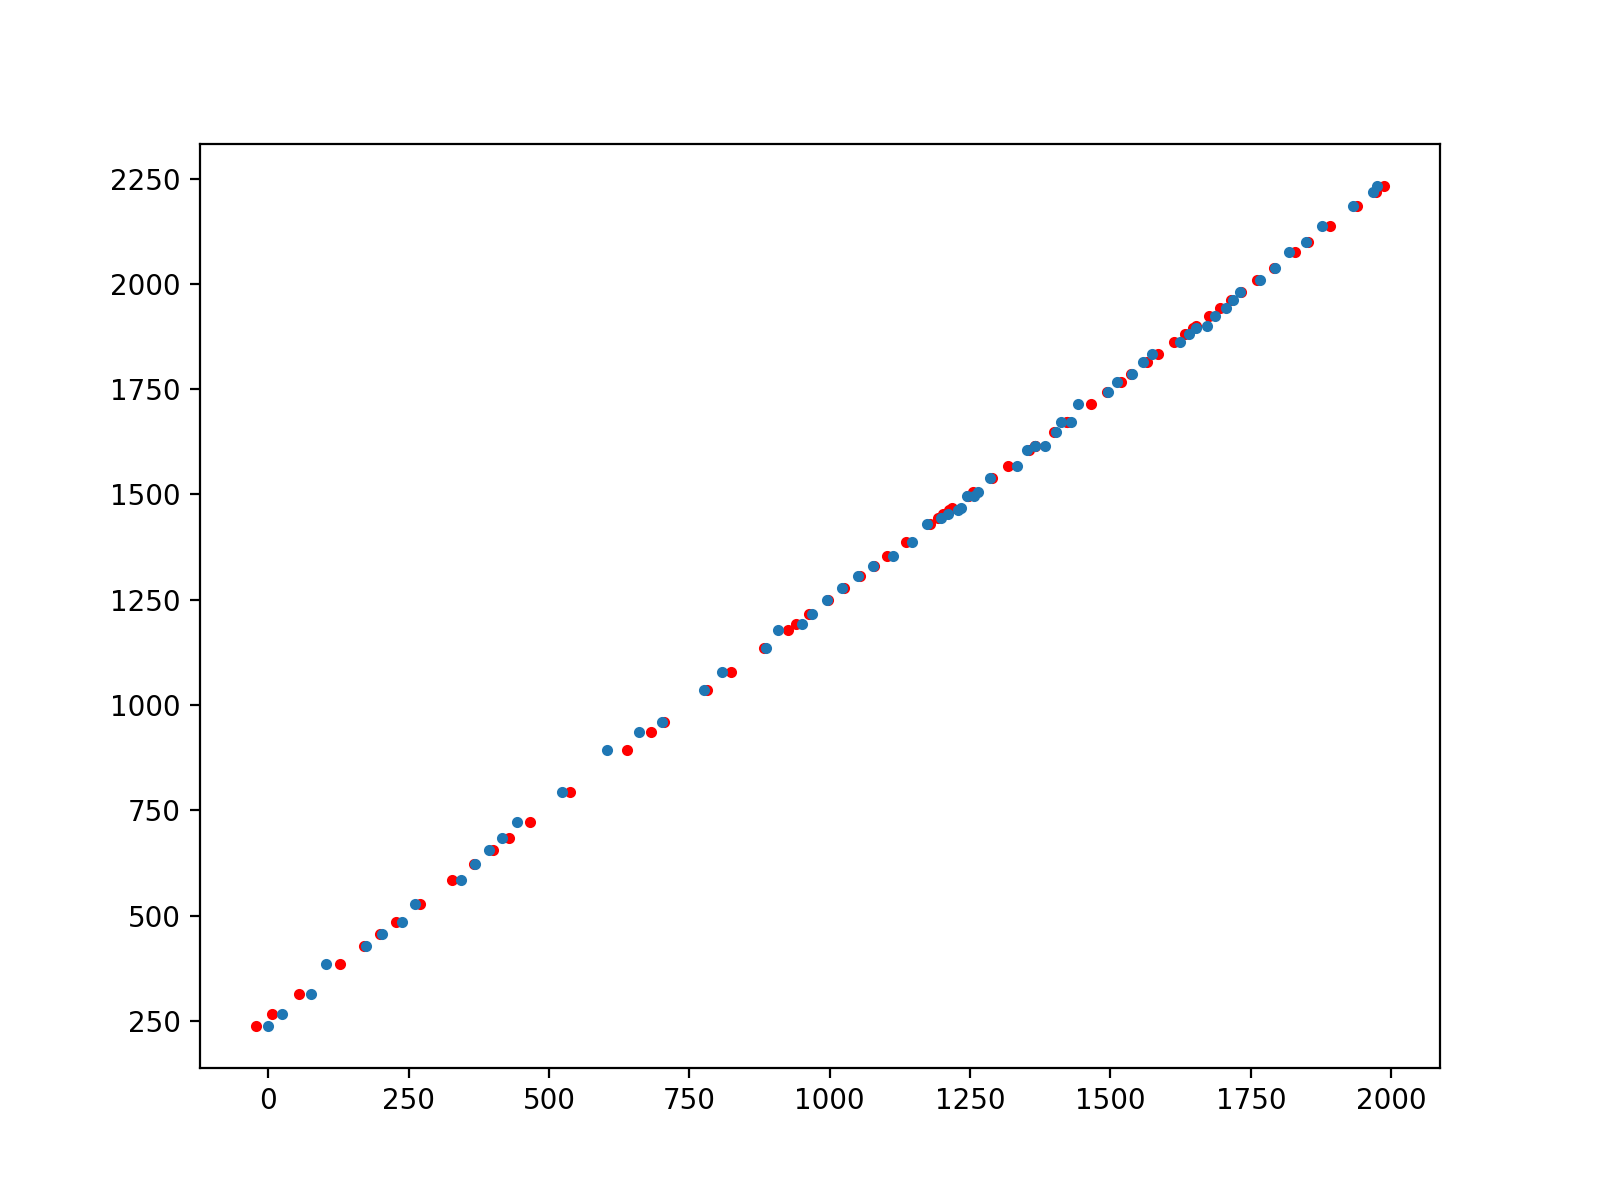

In [80]:
%matplotlib notebook
plt.figure(figsize=[8,6])
plt.plot(ch2rtk.predict(rtk_hit_chn.reshape(-1,1)), rtk_hit_chn, 'r.')
plt.plot(rtk_length[irtk], rtk_hit_chn, '.')

In [81]:
x_chn

array([ 259,  260,  261, ..., 2219, 2220, 2221])

<IPython.core.display.Javascript object>


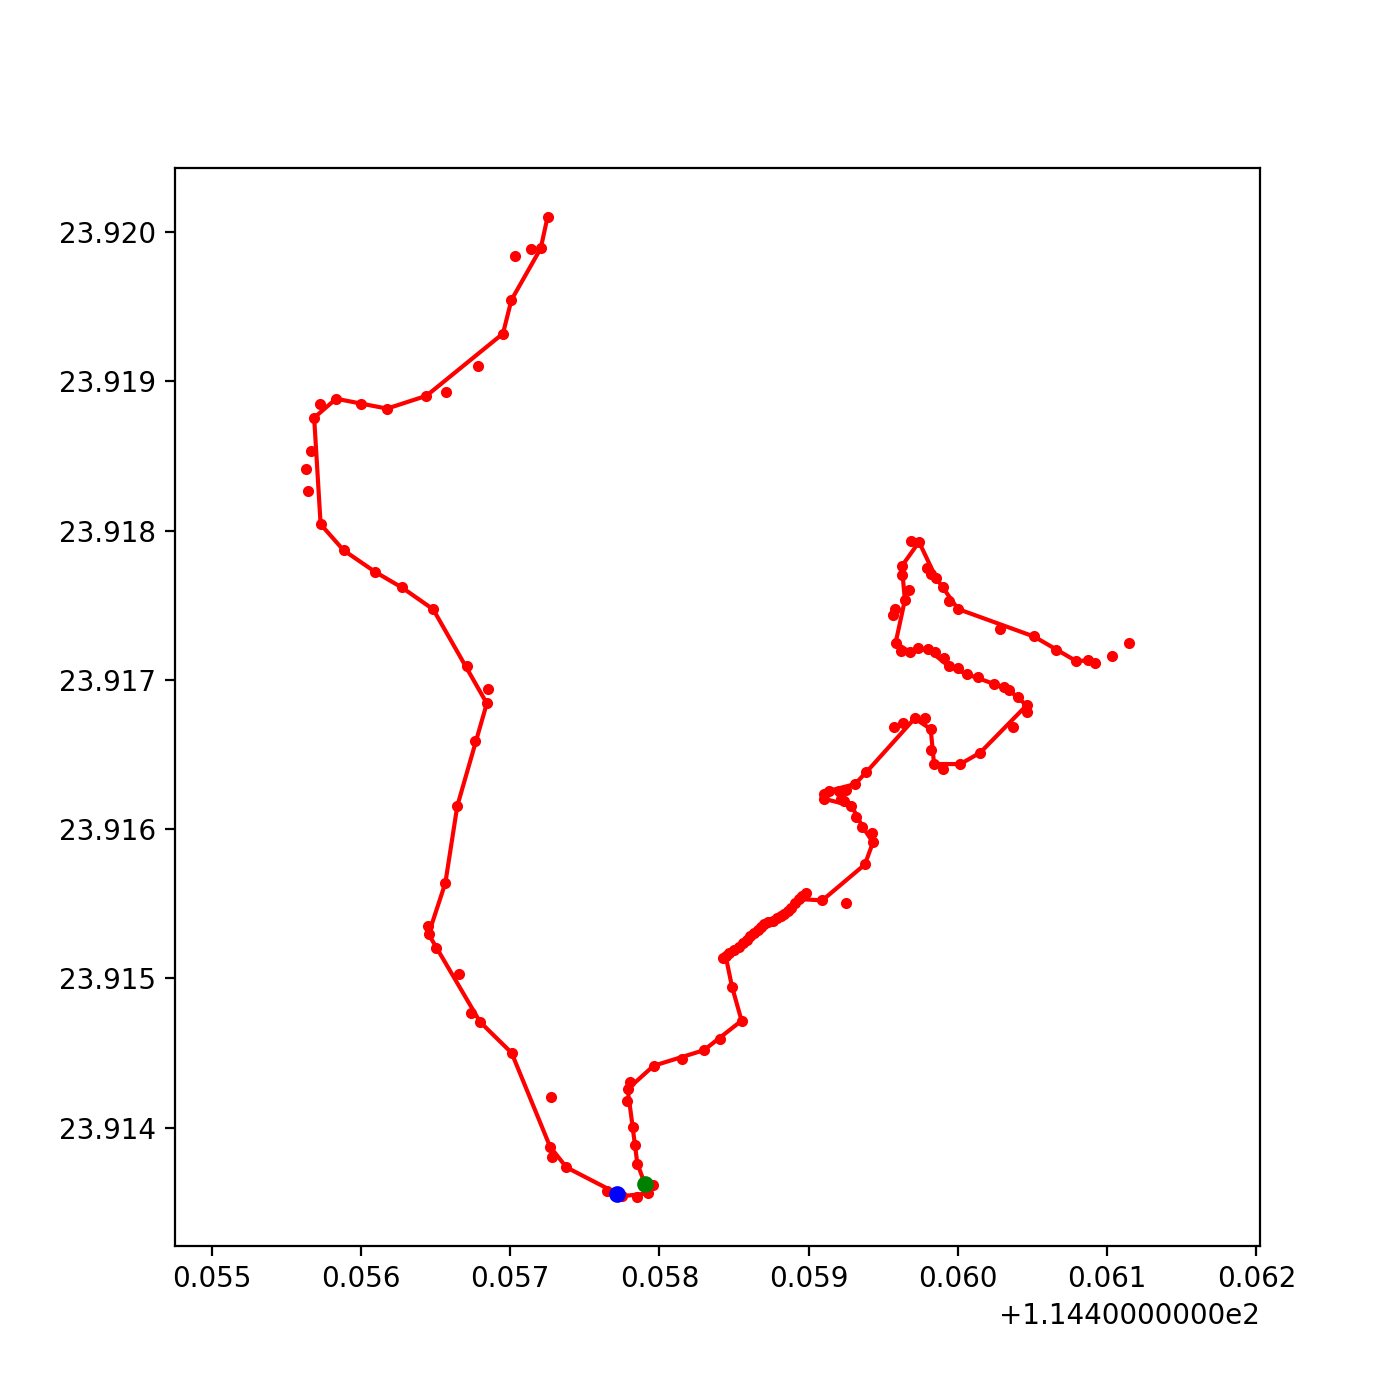

In [82]:
plt.figure(figsize=[7,7])
plt.plot(x_lon, x_lat,'r-')
plt.plot(lon, lat, 'r.')

plt.plot(x_lon[x_chn==1200.], x_lat[x_chn==1200.],'b.', markersize=10)
plt.plot(x_lon[x_chn==1230.], x_lat[x_chn==1230.],'g.', markersize=10)

plt.axis('equal')

# for i in range(len(lon), 100):
#     plt.text(lon[i]+1e-5, lat[i]+1e-5, str(i), color='k')

plt.show()

In [84]:
ch_coor = np.stack([x_chn, x_lat, x_lon, x_dep]).T
np.save('xfj_ch_loc_2024new.npy', ch_coor)

In [83]:
ch_coor

array([[ 265.        ,   23.92010122,  114.45725012,  118.8798    ],
       [ 266.        ,   23.92009479,  114.45724872,  118.81211164],
       [ 267.        ,   23.92008586,  114.45724677,  118.7181723 ],
       ...,
       [2231.        ,   23.91715326,  114.46100905,   97.66584843],
       [2232.        ,   23.91715473,  114.46101825,   97.62060748],
       [2233.        ,   23.9171562 ,  114.46102745,   97.57536652]])